In [42]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import precision_score, classification_report, precision_recall_curve
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [28]:
event_data_test = pd.read_csv("https://stepik.org/media/attachments/course/4852/events_data_test.csv")
submission_data_test = pd.read_csv("https://stepik.org/media/attachments/course/4852/submission_data_test.csv")

In [29]:
submission_score_test = submission_data_test.pivot_table(
    index="user_id",
    columns="submission_status",
    aggfunc="count",
    fill_value=0
).reset_index()
submission_score_test = submission_score_test.drop(["timestamp"], axis =1)

/tmp/ipykernel_4305/3183883126.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  submission_score_test = submission_score_test.drop(["timestamp"], axis =1)


In [30]:
event_score_test = event_data_test.pivot_table(
    index="user_id",
    columns="action",
    aggfunc="count",
    fill_value=0
).reset_index("user_id")
event_score_test = event_score_test.drop(["timestamp"], axis =1)

/tmp/ipykernel_4305/1366299262.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  event_score_test = event_score_test.drop(["timestamp"], axis =1)


In [31]:
users_score_test = event_score_test.merge(submission_score_test , on = "user_id" , how="outer")

/tmp/ipykernel_4305/2822960292.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  users_score_test = event_score_test.merge(submission_score_test , on = "user_id" , how="outer")


In [32]:
users_score_test['discovered'] = users_score_test.step_id.discovered
users_score_test['passed'] = users_score_test.step_id.passed
users_score_test['started_attempt'] = users_score_test.step_id.started_attempt
users_score_test['viewed'] = users_score_test.step_id.viewed
users_score_test['correct'] = users_score_test.step_id.correct
users_score_test['wrong'] = users_score_test.step_id.wrong
users_score_test = users_score_test.drop(["step_id"], axis =1)
users_score_test["is_gone"] = (users_score_test.passed >=35).astype('int')
users_score_test["correct_quality"] = users_score_test.correct / (users_score_test.correct+users_score_test.wrong)
users_score_test = users_score_test.fillna(0)

/tmp/ipykernel_4305/3400582629.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  users_score_test = users_score_test.drop(["step_id"], axis =1)


In [33]:
X_test = users_score_test.drop(["is_gone"], axis = 1)
Y_test = users_score_test[["user_id" , "is_gone"]]
X_test = X_test.set_index("user_id")
Y_test = Y_test.set_index("user_id")

In [35]:
event_data_train = pd.read_csv("https://stepik.org/media/attachments/course/4852/event_data_train.csv")
submission_data_train = pd.read_csv("/home/daniil_ast/programing/python/statistics/submissions_data_train.csv")

In [36]:
submission_score_train = submission_data_train.pivot_table(
    index="user_id",
    columns="submission_status",
    aggfunc="count",
    fill_value=0
).reset_index()
submission_score_train = submission_score_train.drop(["timestamp"], axis =1)


event_score_train = event_data_train.pivot_table(
    index="user_id",
    columns="action",
    aggfunc="count",
    fill_value=0
).reset_index("user_id")
event_score_train = event_score_train.drop(["timestamp"], axis =1)


users_score_train = event_score_train.merge(submission_score_train , on = "user_id" , how="outer")

/tmp/ipykernel_4305/1986633273.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  submission_score_train = submission_score_train.drop(["timestamp"], axis =1)
/tmp/ipykernel_4305/1986633273.py:16: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  event_score_train = event_score_train.drop(["timestamp"], axis =1)
/tmp/ipykernel_4305/1986633273.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  users_score_train = event_score_train.merge(submission_score_train , on = "user_id" , how="outer")


In [37]:
users_score_train['discovered'] = users_score_train.step_id.discovered
users_score_train['passed'] = users_score_train.step_id.passed
users_score_train['started_attempt'] = users_score_train.step_id.started_attempt
users_score_train['viewed'] = users_score_train.step_id.viewed
users_score_train['correct'] = users_score_train.step_id.correct
users_score_train['wrong'] = users_score_train.step_id.wrong
users_score_train = users_score_train.drop(["step_id"], axis =1)
users_score_train["is_gone"] = (users_score_train.passed >=35).astype('int')
users_score_train["correct_quality"] = users_score_train.correct / (users_score_train.correct+users_score_train.wrong)
users_score_train = users_score_train.fillna(0)

/tmp/ipykernel_4305/1531706810.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  users_score_train = users_score_train.drop(["step_id"], axis =1)


In [38]:
X_train = users_score_train.drop(["is_gone"], axis = 1)
Y_train = users_score_train[["user_id" , "is_gone"]]
X_train = X_train.set_index("user_id")
Y_train = Y_train.set_index("user_id")

In [56]:
clf = RandomForestClassifier(random_state=0)
parametrs = {
    "n_estimators":range(1,100,5),
    "criterion":["gini"],
    "max_depth":range(1,11),
    "min_samples_split":range(1,50),
    "min_samples_leaf":range(1,50)
}
search = RandomizedSearchCV(clf, parametrs, cv=4, n_jobs=-1)
search.fit(X_train, Y_train)
best_forest=search.best_estimator_
result = users_score_test['user_id'].to_frame()
result['is_gone'] = (best_forest.predict_proba(X_test))[:, 1]
result[['user_id', 'is_gone']].to_csv(f'predict.csv', index=False)

/home/daniil_ast/.local/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/daniil_ast/.local/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/daniil_ast/.local/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/daniil_ast/.local/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

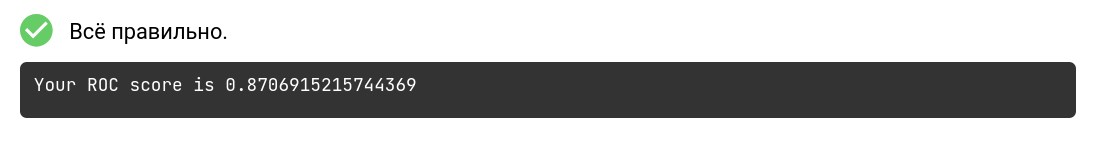